In [1]:
import numpy as np
import os
import pathlib
import sys

if pathlib.Path(os.getcwd()).parents[2] not in sys.path:
    sys.path.append(str(pathlib.Path(os.getcwd()).parents[2]))

from Sensors.BatEcho.Spatializer import Render
from Sensors.BatEcho import Setting as sensorconfig
from Gym.BeaconDocking_v0 import Helper
from Arena import Builder

from Control.SensorimotorLoops.BatEcho import AvoidApproach
from Simulation.Motion import State
from Control.SensorimotorLoops import Setting as controlconfig

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
data = np.load('data.npz')
reference_poses = data['poses']
reference_scores= data['scores']
poses_matrix_reference = reference_poses[reference_scores==1]
beacon_centric_reference = np.copy(poses_matrix_reference)
theta = np.pi*(-0.5)
rotmat = np.asarray([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)], dtype=np.float32).reshape(2,2)
beacon_centric_reference[:,:2] = np.matmul(rotmat, beacon_centric_reference[:,:2].T).T
beacon_centric_reference[:,2] = Builder.wrap2pi(beacon_centric_reference[:,2] + theta)

In [ ]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(poses_matrix_reference[:,0],poses_matrix_reference[:,1], c='r', s=1, alpha=0.01)
ax.quiver(poses_matrix_reference[:,0],poses_matrix_reference[:,1],
        np.cos(poses_matrix_reference[:,2]), np.sin(poses_matrix_reference[:,2]),
          scale=25, width=3e-3, color='r', alpha=0.2)

ax.scatter(beacon_centric_reference[:,0],beacon_centric_reference[:,1], c='k', s=1, alpha=0.01)
ax.quiver(beacon_centric_reference[:,0],beacon_centric_reference[:,1],
        np.cos(beacon_centric_reference[:,2]), np.sin(beacon_centric_reference[:,2]),
          scale=25, width=3e-3, color='k', alpha=0.2)

#ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=150)
#ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=30)
#ax.set_xlim([-2.6,2.6])
#ax.set_ylim([-5,0.])
ax.set_aspect('equal')

In [ ]:
from mpl_toolkits import mplot3d

%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(beacon_centric_reference[:,0], beacon_centric_reference[:,1], np.degrees(beacon_centric_reference[:,2]), c=beacon_centric_reference[:,2], marker='s', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('yaw')
ax.set_ylim([-4, 4])
ax.set_xlim([-7, 1])

In [ ]:
%matplotlib inline

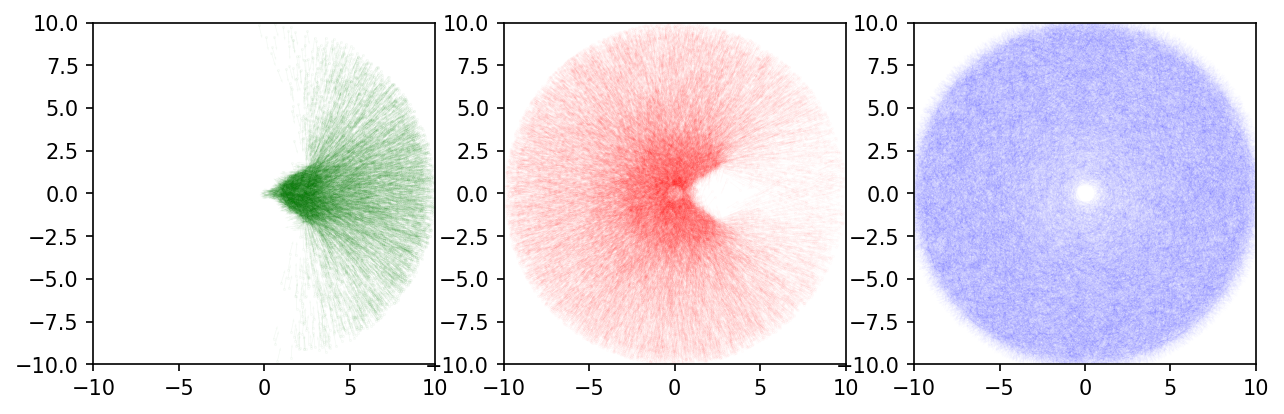

In [2]:
dataset = np.load('dockingZone_dataset.npz')
X = dataset['X']
Y= dataset['Y'].squeeze()
X_doc = X[Y==1]
X_hit = X[Y==-1]
X_out = X[Y==0]
X_out = X_out[np.where((X_out[:,0]!=0)+(X_out[:,1]!=0)+(X_out[:,2]!=0))][:200000]

fig, ax = plt.subplots(1,3,dpi=150, figsize=(10,30))
ax[0].scatter(X_doc[:,0],X_doc[:,1], c='g', s=0.1, alpha=0.05)
ax[0].quiver(X_doc[:,0],X_doc[:,1], np.cos(X_doc[:,2]), np.sin(X_doc[:,2]),
          scale=25, width=2e-3, color='g', alpha=0.05)
ax[1].scatter(X_hit[:,0],X_hit[:,1], c='r', s=0.1, alpha=0.02)
ax[1].quiver(X_hit[:,0],X_hit[:,1], np.cos(X_hit[:,2]), np.sin(X_hit[:,2]),
          scale=25, width=2e-3, color='r', alpha=0.02)
#ax[2].scatter(X_out[:,0],X_out[:,1], c='b', s=0.1, alpha=0.01)
ax[2].quiver(X_out[:,0],X_out[:,1], np.cos(X_out[:,2]), np.sin(X_out[:,2]),
          scale=25, width=2e-3, color='b', alpha=0.01)

for a in ax:
    a.set_xlim([-10, 10])
    a.set_ylim([-10, 10])
    a.set_aspect('equal')


In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(X_hit[:,0],X_hit[:,1], c='r', s=0.1, alpha=0.05)
ax.quiver(X_hit[:,0],X_hit[:,1], np.cos(X_hit[:,2]), np.sin(X_hit[:,2]),
          scale=25, width=2e-3, color='r', alpha=0.05)
ax.scatter(X_doc[:,0],X_doc[:,1], c='g', s=0.1, alpha=0.1)
ax.quiver(X_doc[:,0],X_doc[:,1], np.cos(X_doc[:,2]), np.sin(X_doc[:,2]),
          scale=25, width=2e-3, color='g', alpha=0.1)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_aspect('equal')

In [3]:
N_hit = len(X_hit)
N_doc = len(X_doc)
N_out = len(X_out)
N_hit_percent = N_hit / (N_hit+N_doc+N_out)
N_doc_percent = N_doc / (N_hit+N_doc+N_out)
N_out_percent = N_out / (N_hit+N_doc+N_out)
print('Number of sample: [docked]={0} | [hit]={1} | [out]={2}'.format(N_doc, N_hit, N_out))
print('Class percentage: [docked]={:.2f} | [hit]={:.2f} | [out]={:.2f}'.format(N_doc_percent, N_hit_percent, N_out_percent))


Number of sample: [docked]=12241 | [hit]=54858 | [out]=200000
Class percentage: [docked]=0.05 | [hit]=0.21 | [out]=0.75


In [ ]:
%matplotlib inline

### To learn or not to learn
I think I should construct a train and test dataset. From this cloud.
Aparently, KNClassifier seems the most intuitive for me. However, the disadvantage is the with a large cloud of data. It will be very expensive to during runtime.
-> Let's use KNClassifier as a benchmark
Test a few candidate:
0. KNClassifer (benchmark)
1. Logistic Regression.
2. RBF SVM
3. Gaussian Process --> Do Not Compute!
4. Naive Bayes (Gaussian, Bernoulli, Categorical)

!!! Metrics:
1. Test Accuracy
2. Precision Recall
* Precision = TP/(TP + FP)
* Recall = TP/(TP + FN)
* ROC (receiver operating characteristic curve) curve (TP_rate vs FP_rate):
  * TP_rate = recall = TP/(TP+FN)
  * FP_rate = FP/(FP+TN)
  * Each point on the curve is for a threshold (or decision threshold)
  * Are under this curve indicate performance of a method despite thresholding.
* Precision recall curve: Area under this curve indicate performance.


### Metrics Functions

In [4]:
def getMetrics(Y_hat, Y, classes):
    metrics = {}
    metrics['accuracy'] = np.sum(Y_hat==Y) / len(Y_hat)
    n_class = len(classes)
    TP, FP, TN, FN = np.zeros(n_class), np.zeros(n_class), np.zeros(n_class), np.zeros(n_class)
    for i, k in enumerate(classes):
        TP[i] = np.sum(Y_hat[Y_hat==k] == Y[Y_hat==k])
        FP[i] = np.sum(Y_hat[Y_hat==k] != Y[Y_hat==k])
        TN[i] = np.sum(Y[Y_hat!=k] != k)
        FN[i] = np.sum(Y[Y_hat!=k] == k)
    metrics['precision'] = np.divide(TP, TP+FP)
    metrics['recall'] = np.divide(TP, TP+FN)
    metrics['FP_rate'] = np.divide(FP, FP+TN)
    return metrics

In [5]:
X_set = np.vstack((X_doc, X_hit, X_out))
Y_set = np.vstack((0*np.ones((len(X_doc),1)), 1*np.ones((len(X_hit),1)), 2*np.ones((len(X_out),1)) ))
labels = {'doc': 0, 'hit': 1, 'out': 2}

Train Size = 213679 | Test Size = 53420


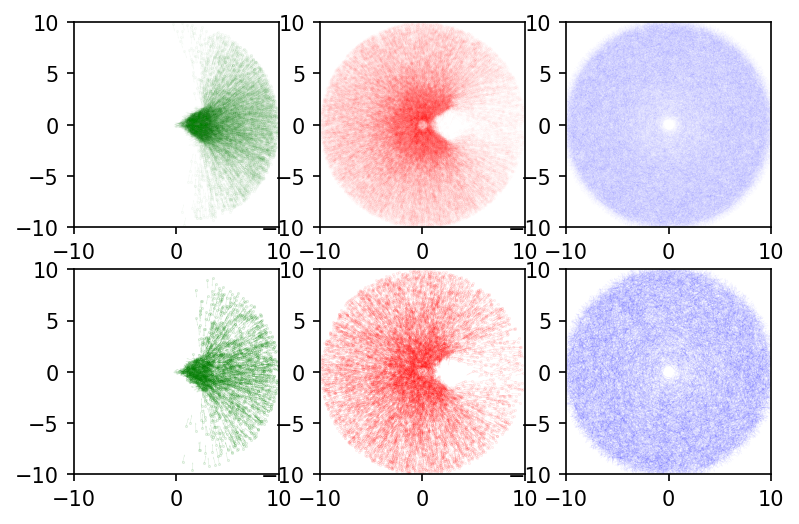

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_set, Y_set.squeeze(), test_size=0.2, random_state=123)
print('Train Size = {0} | Test Size = {1}'.format(len(X_train), len(X_test)))

fig, ax = plt.subplots(2,3,dpi=150)
ax[0,0].scatter(X_train[y_train==0][:,0],X_train[y_train==0][:,1], c='g', s=0.1, alpha=0.05)
ax[0,0].quiver(X_train[y_train==0][:,0],X_train[y_train==0][:,1], np.cos(X_train[y_train==0][:,2]), np.sin(X_train[y_train==0][:,2]),
          scale=25, width=2e-3, color='g', alpha=0.05)
ax[0,1].scatter(X_train[y_train==1][:,0],X_train[y_train==1][:,1], c='r', s=0.1, alpha=0.02)
ax[0,1].quiver(X_train[y_train==1][:,0],X_train[y_train==1][:,1], np.cos(X_train[y_train==1][:,2]), np.sin(X_train[y_train==1][:,2]),
          scale=25, width=2e-3, color='r', alpha=0.02)
#ax[2].scatter(X_out[:,0],X_out[:,1], c='b', s=0.1, alpha=0.01)
ax[0,2].quiver(X_train[y_train==2][:,0],X_train[y_train==2][:,1], np.cos(X_train[y_train==2][:,2]), np.sin(X_train[y_train==2][:,2]),
          scale=25, width=2e-3, color='b', alpha=0.01)

ax[1,0].scatter(X_test[y_test==0][:,0],X_test[y_test==0][:,1], c='g', s=0.1, alpha=0.2)
ax[1,0].quiver(X_test[y_test==0][:,0],X_test[y_test==0][:,1], np.cos(X_test[y_test==0][:,2]), np.sin(X_test[y_test==0][:,2]),
          scale=25, width=2e-3, color='g', alpha=0.2)
ax[1,1].scatter(X_test[y_test==1][:,0],X_test[y_test==1][:,1], c='r', s=0.1, alpha=0.1)
ax[1,1].quiver(X_test[y_test==1][:,0],X_test[y_test==1][:,1], np.cos(X_test[y_test==1][:,2]), np.sin(X_test[y_test==1][:,2]),
          scale=25, width=2e-3, color='r', alpha=0.1)
#ax[2].scatter(X_out[:,0],X_out[:,1], c='b', s=0.1, alpha=0.01)
ax[1,2].quiver(X_test[y_test==2][:,0],X_test[y_test==2][:,1], np.cos(X_test[y_test==2][:,2]), np.sin(X_test[y_test==2][:,2]),
          scale=25, width=2e-3, color='b', alpha=0.05)

for i in range(len(ax)):
    for axx in ax[i]:
        axx.set_xlim([-10, 10])
        axx.set_ylim([-10, 10])
        axx.set_aspect('equal')


### KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNC_metrics={}
for k in range(3,13):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    KNC_metrics[k]=getMetrics(prediction, y_test, classes=list(labels.values()))

In [ ]:
avg_accuracy = 0
for metrics, k in zip(KNC_metrics.values(),KNC_metrics.keys()):
    print('N_neighbor={:}, accuracy={:.2f}, precision={:}, recall={:}'.format(k,metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(KNC_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LogReg_metrics = {}
for C in [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]:
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    LogReg_metrics[C] = getMetrics(prediction, y_test, classes=list(labels.values()))

In [ ]:
avg_accuracy = 0
for metrics, k in zip(LogReg_metrics.values(),LogReg_metrics.keys()):
    #print('C={:}, accuracy={:.2f}'.format(k, metrics['accuracy']))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(LogReg_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

### Support Vector Machine

In [ ]:
from sklearn import svm
gammas = [0.1, 0.3, 0.6, 1, 3, 6, 10]
Cs = [1e-2, 1e-1, 1, 1e1, 1e2]
SVM_metrics = {}
for g in gammas:
    for c in Cs:
        model = svm.SVC(kernel='rbf', C=c, gamma=g)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        SVM_metrics[(c,g)] = getMetrics(prediction, y_test, classes=list(labels.values()))

In [ ]:
avg_accuracy = 0
for metrics, k in zip(SVM_metrics.values(),SVM_metrics.keys()):
    if (metrics['accuracy']<0.9) or (metrics['precision'][0]<0.9): continue
    print('C={:.1f}, gamma={:.1f}, accuracy={:.2f}, precision={:}, recall={:}'.format(k[0],k[1],metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(SVM_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB

NB_metrics = {}
classifiers = {'gaussian': GaussianNB(),
                  'bernoulli': BernoulliNB()}
for key, model in zip(classifiers.keys(), classifiers.values()):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    NB_metrics[key] = getMetrics(prediction, y_test, classes=list(labels.values()))

In [ ]:
avg_accuracy = 0
for metrics, k in zip(NB_metrics.values(),NB_metrics.keys()):
    print('mode='+k+', accuracy={:.2f}'.format(metrics['accuracy']))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(NB_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
hidden_sets = [(4,), (8,), (16,) , (32,),
               (4,4),   (8,8),   (16, 16),
               (4,4,4), (8,8,8), (16, 16, 16)]
NeuNet_metrics = {}
for hidden in hidden_sets:
    model = MLPClassifier(hidden_layer_sizes=hidden, max_iter=100_000)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    NeuNet_metrics[hidden] = getMetrics(prediction, y_test, classes=list(labels.values()))


In [ ]:
avg_accuracy = 0
for metrics, k in zip(NeuNet_metrics.values(),NeuNet_metrics.keys()):
    print('hidden='+str(k)+', accuracy={:.2f}, precision={:}, recall={:}'.format(metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(NeuNet_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

## Result
### Select SVM RBF for classifier
### Papermeter:
C=10, Gamma=1 -> balance Precision Recall
### Emphasize on Precision but low recall
C=0.1, gamma=6.0, accuracy=0.93, precision=[0.96 0.94 0.93], recall=[0.59 0.89 0.99]
Accuracy = 0.03

In [7]:
from sklearn import svm
model1 = svm.SVC(kernel='rbf', C=10., gamma=1.)
model1.fit(X_train, y_train)
prediction1 = model1.predict(X_test)

model2 = svm.SVC(kernel='rbf', C=0.1, gamma=6.)
model2.fit(X_train, y_train)
prediction2 = model2.predict(X_test)

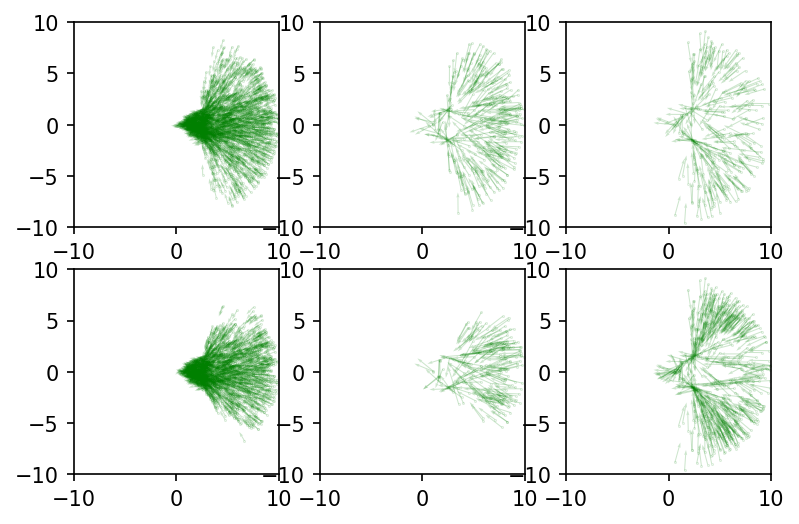

In [8]:
fig, ax = plt.subplots(2,3, dpi=150)
label = 0
# Plot True Positive
X_TP1 = X_test[(prediction1==label) * (y_test==label)]
X_TP2 = X_test[(prediction2==label) * (y_test==label)]
ax[0,0].scatter(X_TP1[:,0],X_TP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,0].quiver(X_TP1[:,0],X_TP1[:,1], np.cos(X_TP1[:,2]), np.sin(X_TP1[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)
ax[1,0].scatter(X_TP2[:,0],X_TP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,0].quiver(X_TP2[:,0],X_TP2[:,1], np.cos(X_TP2[:,2]), np.sin(X_TP2[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)

# Plot False Positive
X_FP1 = X_test[(prediction1==label) * (y_test!=label)]
X_FP2 = X_test[(prediction2==label) * (y_test!=label)]
ax[0,1].scatter(X_FP1[:,0],X_FP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,1].quiver(X_FP1[:,0],X_FP1[:,1], np.cos(X_FP1[:,2]), np.sin(X_FP1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,1].scatter(X_FP2[:,0],X_FP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,1].quiver(X_FP2[:,0],X_FP2[:,1], np.cos(X_FP2[:,2]), np.sin(X_FP2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

# Plot False Negative
X_FN1 = X_test[(prediction1!=label) * (y_test==label)]
X_FN2 = X_test[(prediction2!=label) * (y_test==label)]
ax[0,2].scatter(X_FN1[:,0],X_FN1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,2].quiver(X_FN1[:,0],X_FN1[:,1], np.cos(X_FN1[:,2]), np.sin(X_FN1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,2].scatter(X_FN2[:,0],X_FN2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,2].quiver(X_FN2[:,0],X_FN2[:,1], np.cos(X_FN2[:,2]), np.sin(X_FN2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

for i in range(6):
    ax[int(i/3), i%3].set_xlim([-10,10])
    ax[int(i/3), i%3].set_ylim([-10,10])
    ax[int(i/3), i%3].set_aspect('equal')
    

In [9]:
from joblib import dump
dump (model1, 'dockingZone_classifier.joblib')

['dockingZone_classifier.joblib']